### Importando pandas e arquivo

In [1]:
import pandas as pd
import glob

# Carregar os dados
csv_arquivos = glob.glob('../*.csv')
df = pd.concat([pd.read_csv(f, delimiter=';', on_bad_lines='skip') for f in csv_arquivos], ignore_index=True)

### Transformando dados de texto em número e criando um dicionário para indexar

In [2]:
from sklearn.preprocessing import LabelEncoder

# Inicializando LabelEncoders para cada coluna categórica
label_encoders = {}

# Função para aplicar LabelEncoder e armazenar os mapeamentos
def encode_column(df, column):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

# Aplicando LabelEncoder nas colunas categóricas
categorical_columns = ['bairro', 'hora_minuto', 'sexo', 'municipio','subtipo']
for column in categorical_columns:
    encode_column(df, column)

# Preenchendo valores ausentes na coluna 'idade' com a mediana
df['idade'] = df['idade'].fillna(df['idade'].median())

# Transformar a coluna 'tipo' em numérica e armazenar o encoder
encode_column(df, 'tipo')



### Separando as variáveis que consideramos como relevante

- bairro, hora_minuto, sexo, municipio, idade
> O modelo vai se basear nas variáveis acima e criar um padrão usando arvore de decisão para prever possiveis futuros acidentes 

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Identificando o código correspondente a 'ACIDENTE DE TRANSITO ENVOLVENDO MOTO'
moto_code = label_encoders['subtipo'].transform(['ACIDENTE DE TRANSITO ENVOLVENDO MOTO'])[0]

# Criando a coluna alvo: 1 se acidente envolve moto, 0 caso contrário
df['acidente_moto'] = (df['subtipo'] == moto_code).astype(int)

# Definindo variáveis independentes (features) e dependente (target)
X = df[['bairro', 'hora_minuto', 'sexo', 'municipio', 'idade']]
y = df['acidente_moto']

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Criando o modelo de árvore de decisão
clf = DecisionTreeClassifier()

# Treinando o modelo
clf.fit(X_train, y_train)

# Fazendo previsões
y_pred = clf.predict(X_test)

# Avaliando o modelo
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f'Acurácia: {accuracy}')
print(classification_rep)
print(confusion_mat)


Acurácia: 0.8874570147109087
              precision    recall  f1-score   support

           0       0.94      0.94      0.94    267097
           1       0.20      0.22      0.21     19629

    accuracy                           0.89    286726
   macro avg       0.57      0.58      0.58    286726
weighted avg       0.89      0.89      0.89    286726

[[250116  16981]
 [ 15288   4341]]


 Usamos o dicionário de index criado para relacionar o bairro com o seu respectivo código <br>
 Após isso, a função `prever_acidente` tem como objetivo receber os parâmetros (bairro, hora_minuto, sexo, municipio, idade) <br>
 de uma situação aleatória para prever se haverá um acidente ou não baseado em seu treinamento

In [4]:
# Função para prever a probabilidade de um acidente de moto
def prever_acidente(bairro, hora_minuto, sexo, municipio, idade):
    # Codificar as entradas usando os label_encoders
    bairro_code = label_encoders['bairro'].transform([bairro])[0]
    hora_minuto_code = label_encoders['hora_minuto'].transform([hora_minuto])[0]
    sexo_code = label_encoders['sexo'].transform([sexo])[0]
    municipio_code = label_encoders['municipio'].transform([municipio])[0]
    # Criar um DataFrame com as novas características
    novo_dado = pd.DataFrame({
        'bairro': [bairro_code],
        'hora_minuto': [hora_minuto_code],
        'sexo': [sexo_code],
        'municipio': [municipio_code],
        'idade': [idade]
    })
    
    # Prever a probabilidade de acidente de moto
    probabilidade = clf.predict_proba(novo_dado)[0]
    return 'Alta chance de possivel acidente' if probabilidade[1] > 0.5 else 'Baixa chance de possivel acidente'
# Exemplo de uso da função
resultado = prever_acidente('GRACAS', '12:08:37', 'MASCULINO', 'RECIFE', 30)
resultado = prever_acidente('GRACAS', '12:08:37', 'MASCULINO', 'RECIFE', 30)
resultado2 = prever_acidente('IMBIRIBEIRA', '17:08:37', 'MASCULINO', 'RECIFE', 25)
resultado3 = prever_acidente('RIO DOCE', '22:21:30', 'MASCULINO', 'OLINDA', 19)
resultado4 = prever_acidente('SANTO AMARO', '12:30:30', 'MASCULINO', 'RECIFE', 18)
resultado5 = prever_acidente('SANTO AMARO', '17:25:52', 'MASCULINO', 'RECIFE',  18)
resultado6 = prever_acidente('IBURA', '17:25:52', 'MASCULINO', 'RECIFE',  18)
resultado7 = prever_acidente('LOTEAMENTO CONCEICAO', '17:25:52', 'MASCULINO', 'PAULISTA',  18)
resultado8 = prever_acidente('CENTRO', '12:08:37', 'MASCULINO', 'RECIFE', 18)

print(resultado)
print(resultado2)
print(resultado3)
print(resultado4)
print(resultado5)
print(resultado6)
print(resultado7)
print(resultado8)


Baixa chance de possivel acidente
Baixa chance de possivel acidente
Baixa chance de possivel acidente
Alta chance de possivel acidente
Baixa chance de possivel acidente
Baixa chance de possivel acidente
Baixa chance de possivel acidente
Baixa chance de possivel acidente


Gráfico mostrando o top20 de bairros com maior número de acidentes

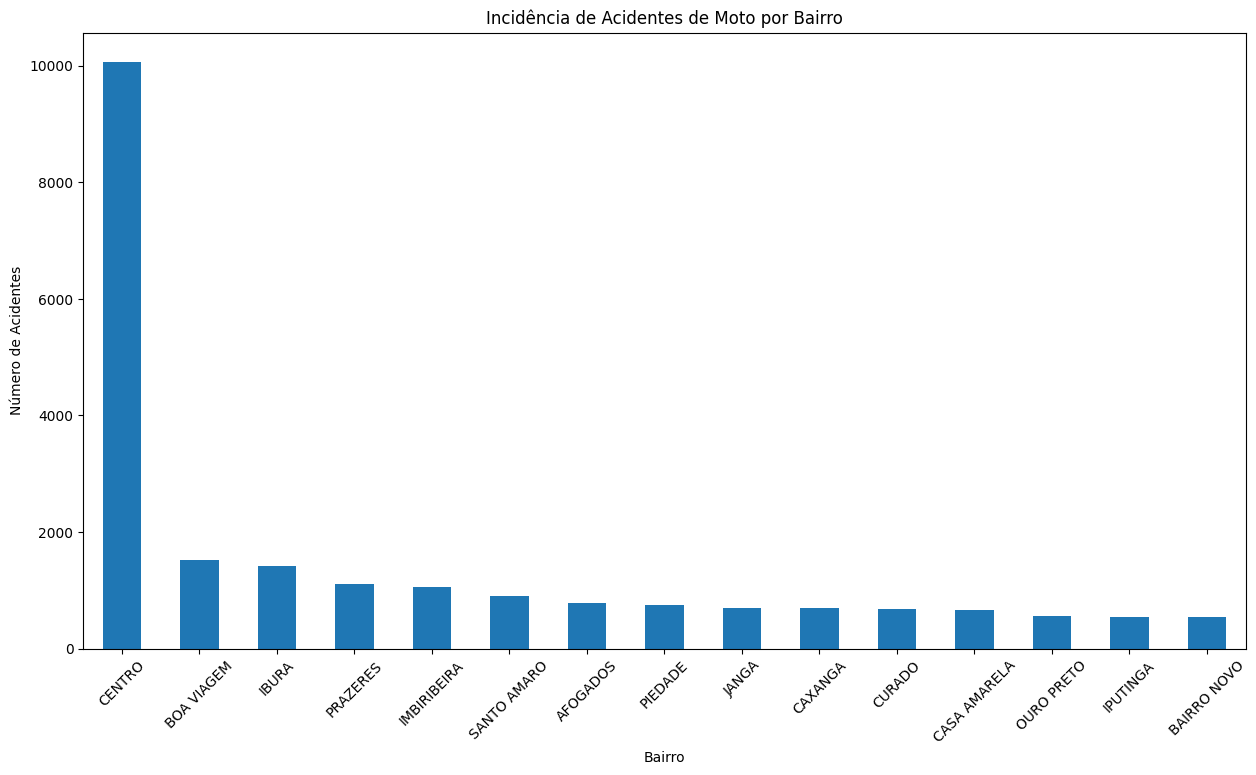

In [5]:
import matplotlib.pyplot as plt

# Identificando o código correspondente a 'ACIDENTE DE TRANSITO ENVOLVENDO MOTO'
moto_code = label_encoders['subtipo'].transform(['ACIDENTE DE TRANSITO ENVOLVENDO MOTO'])[0]

# Filtrar dados de acidentes de moto
df_moto = df[df['subtipo'] == moto_code]

# Contar ocorrências por bairro
bairro_acidentes = df_moto['bairro'].value_counts()
bairro_acidentes.index = label_encoders['bairro'].inverse_transform(bairro_acidentes.index)
bairro_acidentes_top15 = bairro_acidentes[:15]

# Visualizar os bairros com mais acidentes de moto
bairro_acidentes_top15.plot(kind='bar', figsize=(15, 8))
plt.title('Incidência de Acidentes de Moto por Bairro')
plt.xlabel('Bairro')
plt.ylabel('Número de Acidentes')

plt.xticks(rotation=45)

plt.show()


### Analise de numero de acidentes a cada ano

C:\Users\samue\AppData\Local\Temp\ipykernel_23480\3042319120.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_moto['ano'] = pd.to_datetime(df_moto['data'], format='%d/%m/%Y').dt.year


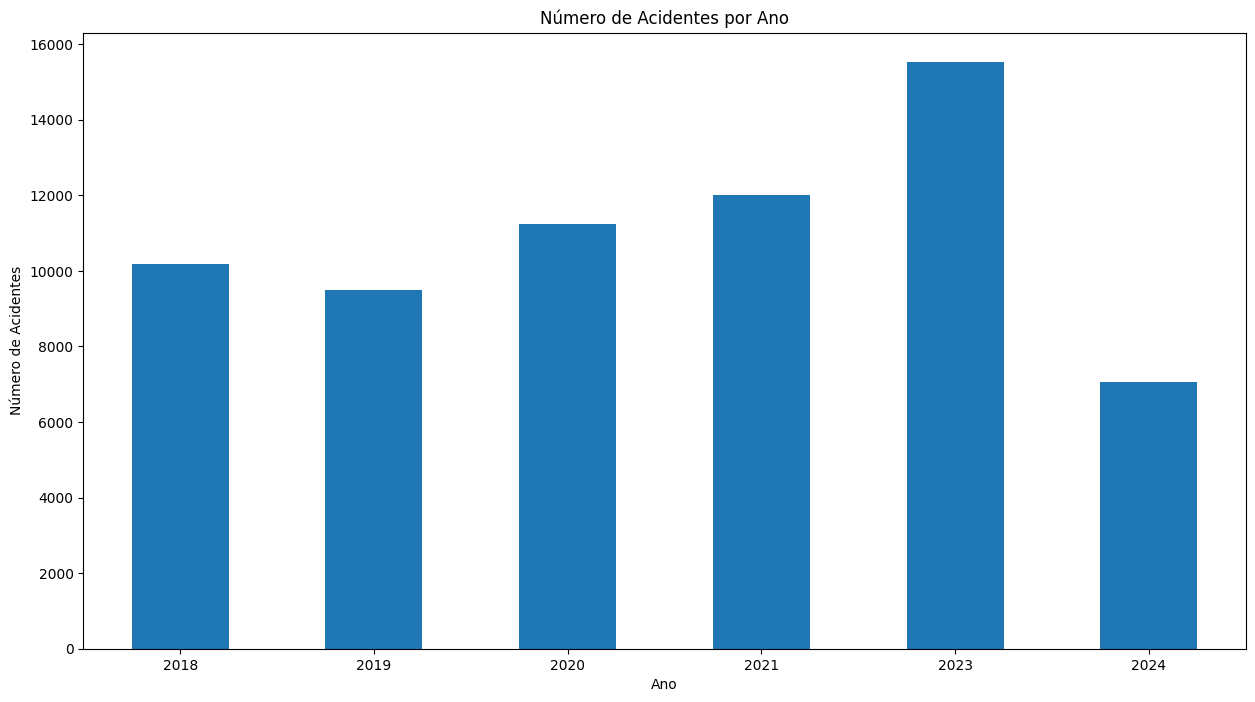

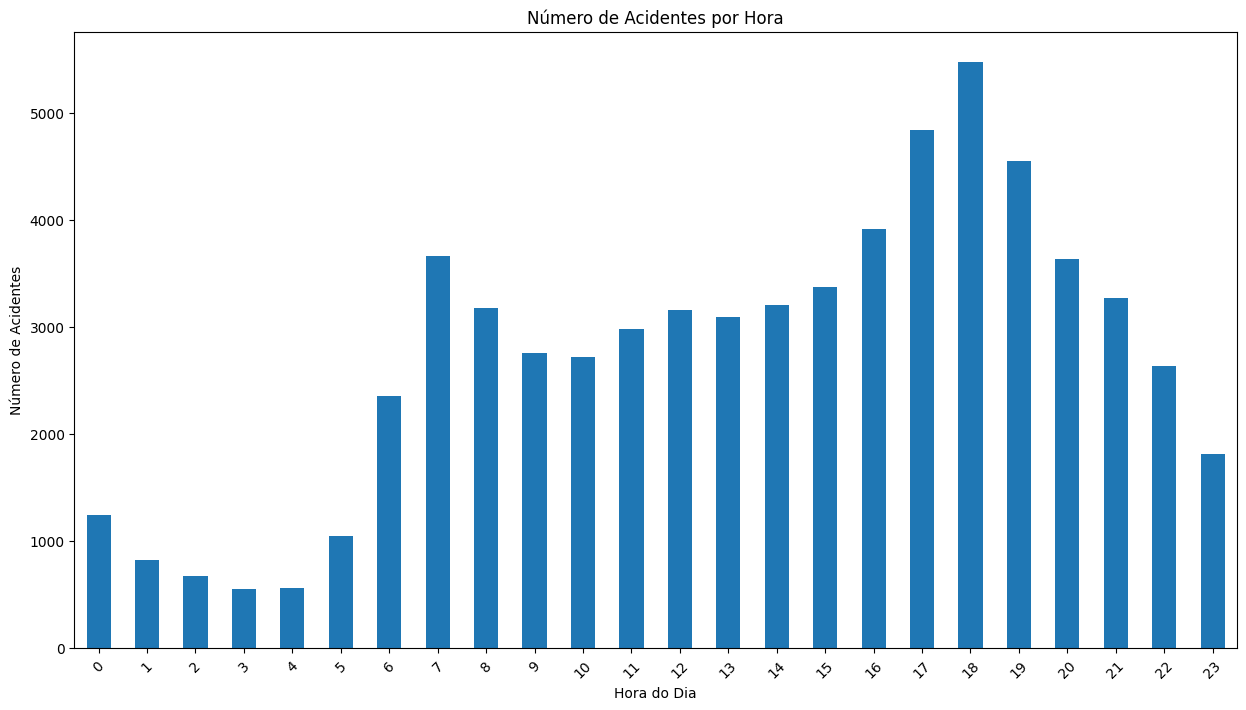

In [6]:
import pandas as pd
# Gráfico de barras com o número de acidentes a cada ano
moto_code = label_encoders['subtipo'].transform(['ACIDENTE DE TRANSITO ENVOLVENDO MOTO'])[0]

# Filtrar dados de acidentes de moto
df_moto = df[df['subtipo'] == moto_code]

df_moto['ano'] = pd.to_datetime(df_moto['data'], format='%d/%m/%Y').dt.year
ano_acidentes = df_moto.groupby('ano').size()


ano_acidentes.plot(kind='bar', figsize=(15, 8))
plt.title('Número de Acidentes por Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Acidentes')
plt.xticks(rotation=0)
plt.show()

hora_acidentes = df_moto['hora_minuto'].value_counts()
hora_acidentes.index = label_encoders['hora_minuto'].inverse_transform(hora_acidentes.index)
hora_acidentes_top = hora_acidentes

horas = hora_acidentes_top.index.str.split(':').str[0].astype(int)
acidentes_por_hora = hora_acidentes_top.groupby(horas).sum()

# Criar um gráfico de barras dos acidentes por hora
plt.figure(figsize=(10, 6))
acidentes_por_hora.plot(kind='bar', figsize=(15, 8))
plt.title('Número de Acidentes por Hora')
plt.xlabel('Hora do Dia')
plt.ylabel('Número de Acidentes')
plt.xticks(rotation=45)
plt.show()